In [2]:
from astropy.table import Table
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
from astropy.io import ascii
import matplotlib.pyplot as plt
from multiprocessing import Pool
# from scipy.integrate import quad

# Time range around the horizon crossing
startTime = 390+1.92224*10**8
stopTime = 500+1.92224*10**8

# indices for the event file
startTimeIndex = 311883
stopTimeIndex = 352360

# read in the data files
tab_ni = Table.read('ni2200300102.mkf', hdu=1)
timeArray = np.array(tab_ni['TIME'])
elevArray = np.array(tab_ni['ELV'])
azArray = np.array(tab_ni['RAM_ANGLE'])
enArray_low = np.array(tab_ni['FPM_XRAY_PI_0035_0200'])
enArray_mid = np.array(tab_ni['FPM_XRAY_PI_0800_1200'])

tab_evt = Table.read('cleanfilt.evt', hdu=1)
eventTime = np.array(tab_evt['TIME'][startTimeIndex:stopTimeIndex])
enArray = np.array(tab_evt['PI'][startTimeIndex:stopTimeIndex])


# interpolate the times.evt to go over the range of elevations.mkf
f = interpolate.interp1d(timeArray, elevArray, kind='linear')
elev_evt = f(eventTime)

g = interpolate.interp1d(timeArray, azArray, kind='linear')
az_evt = g(eventTime)

# calculate altitude based on elevation angle
R = 6378
H = 410
theta = np.arcsin(R/(R+H))
altArray = []
for indx, val in enumerate(elev_evt):
    h = ((R+H)*np.sin(theta+val*(np.pi/180)))-R
    altArray.append(np.float(h))
altArray = np.array(altArray)


# read in MSIS model data
data = ascii.read("msis_model.txt")

height = np.array(data['km'])
density = np.array(data['g/cm^3'])
temp = np.array(data['K'])


def msisSync(Y_msis):
    height[0] = altArray[0]
    height[len(height)-1] = altArray[len(altArray)-1]
    func = interpolate.interp1d(height, Y_msis)
    return np.array(func(altArray))


msisRho = msisSync(density)
msisT = msisSync(temp)


#constants
binSize_all = 1
k = 1.38064852e-23
mu = 28
mp = 1.6726219e-27
g = 9.8
# L = (k*T)/(1000*mu*mp*g)
z0 = 135
# p0 = 0.0012*np.exp(-z0/L)


class EnergyBands:

    def __init__(self, energy_band, bin_size):
        self.energy_band = energy_band
        self.bin_size = bin_size
        self.time, self.energies = EnergyBands.enSplit(self)
        self.alt = EnergyBands.altSplit(self)
        self.rate, self.new_alt, self.binTime = EnergyBands.countRate(self)
        self.T_pre = EnergyBands.msisSplit(self, msisT)
        self.rho_pre = EnergyBands.msisSplit(self, msisRho)
        self.rho_msis, self.T_msis = EnergyBands.countRateSync(self)
        self.perc_trans = EnergyBands.percTrans(self)
        self.L_msis = EnergyBands.atmHeight(self)
        # self.sigmaN = EnergyBands.Sigma(self)
        # self.trans_model = Transmit(self.new_alt, self.sigmaN)
        self.sigmafit_popt, self.sigmafit_pcov = EnergyBands.modelFit_sigma(self)
        self.modelDensity = EnergyBands.hydroStaticModel(self)



    # function that splits the altitudes based on energy bands
    def altSplit(self):
        index = np.where((enArray >= self.energy_band[0]) & (
            enArray < self.energy_band[1]))
        return altArray[index[0]]


    # function that deduces the number of counts per bin size
    def countRate(self):
        binCounts = []
        binTime = []
        altitude = []
        for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
            desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
            if len(self.alt[desind[0]]) != 0:
                binCounts.append(np.size(desind[0]))
                altitude.append(np.mean(self.alt[desind[0]]))
                binTime.append(np.mean(self.time[desind[0]]))
        return np.array(binCounts), np.array(altitude), np.array(binTime)


    def countRateSync(self):
        rho = []
        temp = []
        for i in np.arange(min(self.time), max(self.time)+self.bin_size, self.bin_size):
            desind = np.where((self.time >= i) & (self.time < i + self.bin_size))
            if len(self.alt[desind[0]]) != 0.:
                rho.append(np.mean(self.rho_pre[desind[0]]))
                temp.append(np.mean(self.T_pre[desind[0]]))
        return np.array(rho), np.array(temp)


    # function that makes a list of times corresponding to each energy range
    def enSplit(self):
        index = np.where((enArray >= self.energy_band[0]) & (
            enArray < self.energy_band[1]))
        return eventTime[index[0]], enArray[index[0]]/100


    def percTrans(self):
        plateau = np.where(((self.new_alt > 200) & (self.new_alt < 250)))
        avg = np.mean(self.rate[plateau[0]])
        return (self.rate/avg)*100


    # functions to make the atmospheric model
    # altArray=h in mathematica


    def atmHeight(self):
        return np.array((k*self.T_msis)/(1000*mu*mp*g))


    def Sigma(self):
        c = np.float(-3)
        return (3.31*10**3)*(np.mean(self.energies)/100)**c


    # i is the index in altArray
    def Z(self, x, i, Alt):
        return np.sqrt(x**2+(R+Alt[i])**2)-R


    # def Rho(x, i, Alt, p0, l):
        # return p0*np.exp(-(Z(x, i, Alt)-z0)/l)


    # numerical integration
    def Transmit(self, sigma):
        elem = 500
        tau = []
        dist = 2*np.sqrt((R+H)**2-(R+self.new_alt)**2)
        for hi in range(len(self.new_alt)):
            f = 0
            x2 = (dist[hi]*10**5)/2
            X = np.linspace(0, x2, elem)
            for n in X:
                dx = x2/elem
                f += self.rho_msis[hi]*dx  # this used to refer to Rho()
            tau.append(-2*sigma*f)
        tau = np.array(tau)
        trans = 100*np.exp(tau)
        return np.array(trans)


    def msisSplit(self, msis_col):
        index = np.where((enArray >= self.energy_band[0]) & (enArray < self.energy_band[1]))
        return msis_col[index[0]]


    def modelFit_sigma(self):
        popt, pcov = curve_fit(EnergyBands.Transmit, self, self.perc_trans)
        return popt, pcov
    
    
    # calculating fit uncertrainty based on parameter uncertainties at the point with x=X -- this will need to change...
    def paramUnc(self, Popt, Pcov, X):
        Popt.tolist()
        fVal = SeventhOr(startTime + X, *Popt)
        frac_unc_params = []
        added_frac_unc = 0

        for paramIn in range(len(Popt)):
            Popt[paramIn] = Popt[paramIn] + np.sqrt(abs(Pcov[paramIn][paramIn]))
            fNew = SeventhOr(startTime + X, *Popt)
            frac_unc = abs(fNew-fVal)/fVal
            frac_unc_params.append((frac_unc)**2)

        for i in range(len(frac_unc_params)):
            added_frac_unc += frac_unc_params[i]

        return np.sqrt(added_frac_unc)
    
    
    def hydroStaticModel(self):
        numInt = []
        A = []
        T_z = []
        T_zdz = []
        Rho_zdz = []
        Rho_z = []
        f = 0
        for j in np.arange(len(self.rho_msis),0,-1):
            i_z = j - 1
            i_zdz = j - 2
            A.append((self.new_alt[i_zdz]**2)*(k/(g*mu*mp)))
            T_z.append(self.T_msis[i_z])
            T_zdz.append(self.T_msis[i_zdz])
     
        upperIndex = len(self.new_alt) - 1
        index_zdz = len(self.new_alt) - 2
        index_z = index_zdz - 1
        for indx in np.arange(len(self.rho_msis),0,-1):
            if (indx == len(self.rho_msis)):
                f = 0
                rho0 = self.rho_msis[len(self.rho_msis)-1] #starting point ~ 10e-14
                loops = upperIndex - index_zdz
                for i in range(loops):
                    f += rho0 * self.new_alt[index_zdz]**2
                    index_zdz += 1
                numInt.append(f)
                Rho_z.append(((numInt[0]/A[0])+T_zdz[0]*rho0)/T_z[0])
            else:
                f = 0
                rho0 = Rho_z[len(Rho_z)-1]
                loops = upperIndex - index_zdz
                for i in range(loops):
                    f += rho0 * self.new_alt[index_zdz]**2
                    index_zdz += 1
                numInt.append(f)
                Rho_z.append(((numInt[len(numInt)-1]/A[index_z])+T_zdz[index_z]*rho0)/T_z[index_z])
                ## does rho0 = Rho_zdz in this equation ??
            
        numInt.reverse()
        Rho_z.reverse()
        
        return np.array(Rho_z)
        

In [3]:
lowEn = [30, 70]

low_en = EnergyBands(lowEn, binSize_all)

In [4]:
len(low_en.rho_msis)

89

In [5]:
low_en.modelDensity

array([7.55006069e-08, 6.41756132e-08, 5.45493540e-08, 4.63670212e-08,
       3.94120279e-08, 3.35002745e-08, 2.84752765e-08, 2.42040218e-08,
       2.05734497e-08, 1.74874588e-08, 1.48643625e-08, 1.26347273e-08,
       1.07395345e-08, 9.12861820e-09, 7.75933724e-09, 6.59544666e-09,
       5.60613817e-09, 4.76522468e-09, 4.05044712e-09, 3.44288528e-09,
       2.92645692e-09, 2.48749216e-09, 2.11437154e-09, 1.79721854e-09,
       1.52763808e-09, 1.29849434e-09, 1.10372186e-09, 9.38165004e-10,
       7.97441464e-10, 6.77826273e-10, 5.76153206e-10, 4.89730968e-10,
       4.16271955e-10, 3.53831698e-10, 3.00757400e-10, 2.55644178e-10,
       2.17297881e-10, 1.84703479e-10, 1.56998195e-10, 1.33448668e-10,
       1.13431540e-10, 9.64169556e-11, 8.19545366e-11, 6.96614618e-11,
       5.92123324e-11, 5.03305589e-11, 4.27810400e-11, 3.63639391e-11,
       3.09093952e-11, 2.62730258e-11, 2.23321058e-11, 1.89823187e-11,
       1.61349954e-11, 1.37147669e-11, 1.16575695e-11, 9.90894915e-12,
      

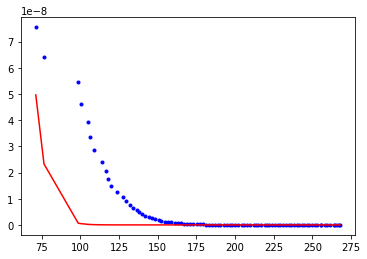

In [13]:
plt.plot(low_en.new_alt, low_en.modelDensity, 'b.')
plt.plot(low_en.new_alt, low_en.rho_msis, 'r-')

In [7]:
np.arange(len(low_en.rho_msis),0,-1)

array([89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73,
       72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56,
       55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39,
       38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22,
       21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,
        4,  3,  2,  1])

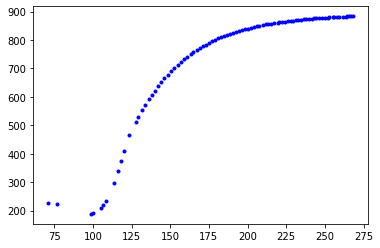

In [8]:
plt.plot(low_en.new_alt, low_en.T_msis, 'b.')